In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator()

# ImageNet mean subtraction (in RGB order) 
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [0]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	directory="/content/Dataset/train",
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=256)

# initialize the validation generator
valGen = valAug.flow_from_directory(
  directory="/content/Dataset/valid",
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32)

Found 6506 images belonging to 7 classes.
Found 1504 images belonging to 7 classes.


In [0]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(7, activation="softmax")(headModel)

model2 = Model(inputs=baseModel.input, outputs=headModel)


[INFO] preparing model...
94773248/94765736 [==============================] - 1s 0us/step


In [0]:
for layer in baseModel.layers:
	layer.trainable = False
    
opt = Adam(lr=1e-3)
model2.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=['accuracy'])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet_1fc256_head_{epoch:03d}.h5', monitor='val_accuracy', verbose=1, save_best_only=True,  mode='max', save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

history2 = model2.fit(
	trainGen,
	validation_data=valGen,
  class_weight=class_weight,
  epochs=100,
  callbacks=[checkpoint,early],
  verbose=1)

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.3710
Epoch 00001: val_accuracy improved from -inf to 0.53391, saving model to resnet_1fc256_head_001.h5
26/26 [==============================] - 130s 5s/step - loss: 1.8128 - accuracy: 0.3710 - val_loss: 1.2810 - val_accuracy: 0.5339
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 1.3787 - accuracy: 0.5103
Epoch 00002: val_accuracy improved from 0.53391 to 0.58311, saving model to resnet_1fc256_head_002.h5
26/26 [==============================] - 129s 5s/step - loss: 1.3787 - accuracy: 0.5103 - val_loss: 1.1531 - val_accuracy: 0.5831
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 1.2563 - accuracy: 0.5343
Epoch 00003: val_accuracy did not improve from 0.58311
26/26 [==============================] - 132s 5s/step - loss: 1.2563 - accuracy: 0.5343 - val_loss: 1.1501 - val_accuracy: 0.5791
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 

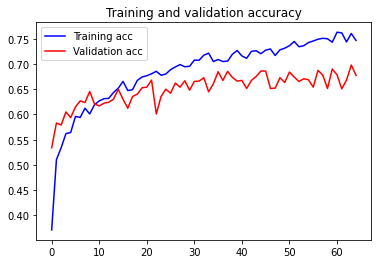

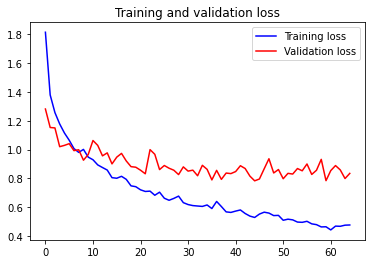

In [0]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
tsdata = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
tsdata.mean = mean
test_generator = tsdata.flow_from_directory(directory="/content/Dataset/test", class_mode="categorical", target_size=(224,224), shuffle=False, batch_size=1)

#model = load_model('test0002.h5')
model2.load_weights('/content/resnet_1fc256_head_022.h5')

results = model2.evaluate(test_generator)
print(results)

test_generator.reset()

predIdxs = model2.predict(test_generator)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))
print(confusion_matrix(test_generator.classes, predIdxs))



Found 2005 images belonging to 7 classes.
2005/2005 [==============================] - 32s 16ms/step - loss: 0.8311 - accuracy: 0.6828
[0.831104040145874, 0.6827930212020874]
